In [56]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.optimize import minimize
# from sklearn import datasets
from scipy.stats import multivariate_normal, norm

In [57]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape

def objective_1D(z, y, A, G, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G
    xc = G.eval(zc)
    Dx = G.jac(zc)

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc   = Dx.H(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective_1D, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # extract complex values
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, zhat

In [88]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length-10)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals

def cut_off_lowpass(data, highcut):
    data = np.atleast_2d(data)
    n = data.shape[1] # will not go well if X is higher dim
    k = fftfreq(n,1)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    
    data_fft = fft(data)
    data_fft[:,cut_off] = 0
    new_data = np.real(ifft(data_fft, axis=1)) # also only works for real data
    return (new_data, cut_off) if data.shape[0] > 1 else (new_data[0], cut_off)

# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

def ambiguityconst(windows):
    '''
    input:
        windows     window functions (length, number of windows/measurements)
    '''
    mx = len(windows[0,:])
    c = 0
    for i in range(2):
        for j in range(mx): 
            mask_test = Ambiguity(windows[:,j], i)
            temp_max = 1/abs(mask_test).min() #potential hazard of dividing by small numbers
            if temp_max > c:
                c = temp_max
                remember_mask_index = j
    return c, remember_mask_index

# compute stability constant
def stabilityconst(n, x, delta, c):
    '''
    input:
        n       signal gridsize
        x       signal set, specified as (number of samples, length of sample)
        delta   threshold
        c       ambiguity function threshold   
    output:
        constant bound for reconstruction
    '''
    max_norm = np.max(np.linalg.norm(x, axis = 1)) # along rows
    C = c/delta*(1 + np.sqrt(2*n*max_norm)/delta)
    return C

def low_lip(n,p,q,mx,max_mask,K):
    '''
    Lower lipschitz bound, except for the universal constant factor
    '''
    return (q*np.sqrt(n))/(p*np.sqrt(mx)*max_mask*K**(3/2))

In [69]:
# define experiment
def run_experiment(Xtrue, A, G, sigmas):
    nsigmas = len(sigmas)
    k       = G.shape[1]
    Xhat    = np.zeros((n,nsamples,nsigmas),dtype=complex)
    errors  = np.zeros((nsamples,nsigmas))
    zhat    = np.zeros((k,nsamples,nsigmas),dtype=complex)
    
    for i in range(nsamples):
        for j in range(nsigmas):
             errors[i,j], Xhat[:,i,j], zhat[:,i,j] = reconstruct(Xtrue[i,:], A, G, sigma = sigmas[j])
    
    return Xhat, errors, zhat

def plot_experiment(Xhat, errors, Xtrue, sigmas):
    nsigmas = len(sigmas)
    
    fig,ax  = plt.subplots(nsigmas,5,sharey=True)

    for j in range(nsigmas):
        for i in range(5):
            ax[j,i].plot(domain,Xtrue[i,:],'k--')
            ax[j,i].plot(domain,np.real(Xhat[:,i,j]),'r')
            ax[j,i].set_ylim([-0.2,0.2])
            ax[j,i].set_aspect(1)

    fig.tight_layout()
    plt.show()
    print('sigma    | error (std)')
    for j in range(nsigmas):
        print('%1.2e | %1.2e (%1.2e)'%(sigmas[j],np.mean(errors[:,j]),np.std(errors[:,j])))

In [127]:
# parameters
delta    = 0.1 # threshold
nsamples = 5  # number of samples to generate for validation
n        = 1000  # grid size for signal
mx       = 75 # number of measurement masks
p        = 0.1 # lower bound C_p,q
q        = 1.5 # higher bound C_p,q
bandwidth = .25 # relative bandwidth for generative model \in (0,1]
windowcut = .125 # cut off frequencies windows
sigmas   = [1e-3, 1e-2, 1e-1] # noise levels to use for validation

# grid
domain   = np.linspace(0,1,n)

(5, 1000)


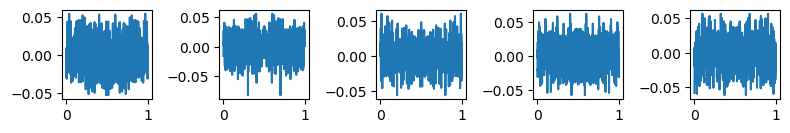

In [128]:
# create data set Cp,q
pm = np.array([-1,1])
pm_vec = np.random.choice(pm, size=(nsamples,n))
fouriervectors = np.random.uniform(p,q, size=(nsamples,n))
fv_signed = pm_vec*fouriervectors

Xtrue = ifft(fv_signed)
print(Xtrue.shape)

fig,ax = plt.subplots(1,5, figsize=(8,2))

for i in range(5):
    ax[i].plot(domain,np.real(Xtrue[i,:]))
    #ax[i].set_aspect(1)
    ax[i].set_box_aspect(1)
    
fig.tight_layout()
plt.show()

In [129]:
# describes mx window functions of length n
windows = np.random.randint(0,2,size=(n,mx))

# windows locally supported in fourier space
cut_windows, cut_indices = cut_off_lowpass(windows.T,windowcut) 
cut_windows = cut_windows.T
print(len(cut_indices))

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(windows[:,i])

# compute max || a ||
max_mask = np.max(np.abs(np.conj(fft(cut_windows))))
print(max_mask)

#fig, ax = plt.subplots()
#ax.plot(domain,cut_windows)
#plt.show()

749
43.43100292156882


In [130]:
# define operators
m    = mx * n
MF   = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

freq   = fftfreq(n)
S      = np.eye(n)[:,np.abs(freq)<=bandwidth]
k      = S.shape[1]
Gfun   = lambda z : ifft(S@z)
Gjac   = lambda p : LinearOperator((n,k), matvec = lambda z : ifft(S@z), rmatvec = lambda x : (S.T@fft(x))/n)
G      = Op(fun = Gfun, jac = Gjac, shape=(n,k))

I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

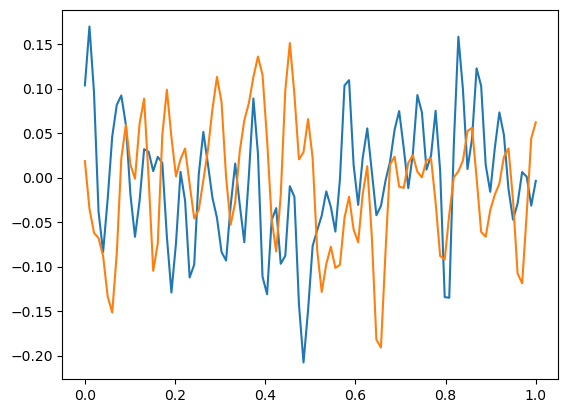

In [64]:
# for random input, this is the kind of signal the model generates
z = np.random.randn(k) + 1j*np.random.randn(k)
plt.plot(domain, np.real(G.eval(z)))
plt.plot(domain, np.imag(G.eval(z)))

In [131]:
Xhat1, errors1, zhat1 = run_experiment(Xtrue, A, I, sigmas)
lip_cnst = low_lip(n,p,q,mx,max_mask,n/4)
print(lip_cnst)

0.0003190441281214257


In [112]:
Xhat2, errors2, _ = run_experiment(Xtrue, A, G, sigmas)

In [ ]:
X_complex = np.ones((5,64)) + 1j*X_filtered
Xhat3, errors3, zhat3 = run_experiment(X_complex, A, I, sigmas)

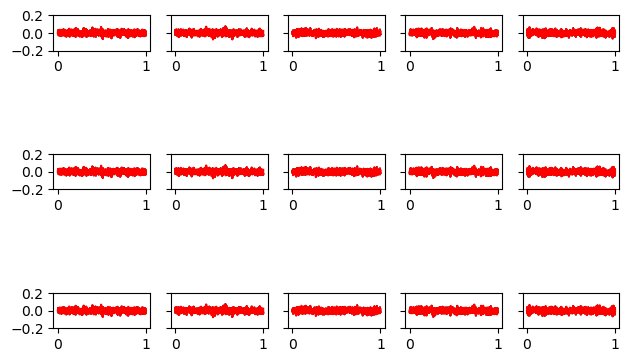

sigma    | error (std)
1.00e-03 | 3.06e-04 (1.27e-05)
1.00e-02 | 3.06e-03 (1.02e-04)
1.00e-01 | 3.27e-02 (4.48e-03)


In [132]:
plot_experiment(np.imag(Xhat1), errors1, np.imag(Xtrue), sigmas)

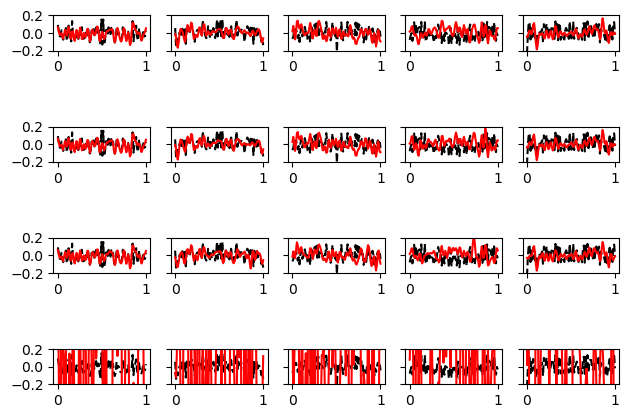

sigma    | error (std)
1.00e-03 | 1.23e+00 (2.83e-01)
1.00e-02 | 1.23e+00 (2.86e-01)
1.00e-01 | 1.23e+00 (2.74e-01)
1.00e+03 | 2.12e+01 (8.07e-01)


In [72]:
plot_experiment(np.real(Xhat2), errors2, np.real(Xtrue), sigmas) 

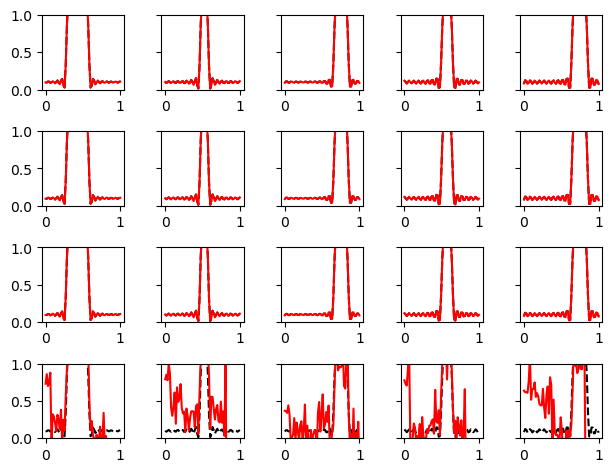

sigma    | error (std)
1.00e-03 | 1.41e-06 (4.00e-07)
1.00e-02 | 1.65e-05 (7.53e-06)
1.00e-01 | 1.23e-04 (3.12e-05)
1.00e+03 | 4.62e-01 (1.58e-01)


In [ ]:
plot_experiment(np.imag(Xhat3), errors3, np.imag(X_complex), sigmas) 